### Table of Contents

* [1. Data Preperation](#chapter1)
* [2. Modeling](#chapter2)
    * [2.1. VAR Model](#section_2_1)
        * [2.1.1. Using Train Set Version 1](#section_2_1_1)
        * [2.1.2. Using Train Set Version 2](#section_2_1_2)
    * [2.2. VARMAX Model](#section_2_2)
        * [2.2.1. Using Train Set Version 1](#section_2_2_1)
        * [2.2.2. Using Train Set Version 2](#section_2_2_2)   

# Data Preperation <a class="anchor" id="chapter1"></a>

The cell below is the necessary steps to prepare data for modeling. Please see the EDA notebook for details.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from statsmodels.tsa.api import VAR
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.tsa.statespace.varmax import VARMAX

np.random.seed(3)

In [2]:
### Electricity Consumption Dataset ###

preview_e = pd.read_csv("Electric_Consumption_And_Cost__2010_-_April_2020_.csv")

preview_e['DATE'] = pd.to_datetime(preview_e['Service End Date'], format="%m/%d/%Y")

preview_e.set_index('DATE', inplace=True)

Manhattan = preview_e.loc[preview_e['Borough'] == 'MANHATTAN']

electric_manhattan = Manhattan.resample('MS').mean()

electric_manhattan = pd.DataFrame(electric_manhattan['Consumption (KWH)'])

### Weather Dataset ### 

preview_w = pd.read_csv('nyc_weather.csv')

preview_w['DATE'] = pd.to_datetime(preview_w['DATE'], format="%Y/%m")

keep = ['DATE', 'NAME', 'CDSD', 'EMNT', 'EMXT', 'HDSD', 'TAVG', 'TMAX', 'TMIN']

preview_w = preview_w[keep]

preview_w = preview_w.rename(columns={'CDSD': 'Cooling Degree Days Season',
                                      'EMNT': 'Extreme Minimum Temperature',
                                      'EMXT': 'Extreme Maximum Temperature',
                                      'HDSD': 'Heating Degree Days Season',
                                      'TAVG': 'Average Temperature',
                                      'TMAX': 'Maximum Temperature',
                                      'TMIN': 'Minimum Temperature'})

preview_w.set_index('DATE', inplace=True)

central_park = preview_w.loc[preview_w['NAME'] == 'NY CITY CENTRAL PARK, NY US']    

weather_central_park = central_park.resample('MS').mean()

weather_central_park = weather_central_park.loc[:'2021-02-01']

### Merge Datasets ###

manhattan_data = electric_manhattan.merge(weather_central_park, left_index=True, right_index=True)

### Train-Validation-Test Split ###

data = manhattan_data['2012-01-01':'2017-12-01'] # 2nd version of the train set
train = data[:'2016-12-01']
val = data['2017-01-01':]
test = manhattan_data['2019-01-01':]

print('manhattan_data shape: ', manhattan_data.shape)
print('data shape: ', data.shape)
print('train shape: ', train.shape)
print('val shape: ', val.shape)
print('test shape: ', test.shape)

# using lengths of val set and test set as the periods I want to predict
nobs = len(val)
test_nobs = len(test)

### Stationarity ###

# differencing version 1 train set
df_differenced = train.diff().dropna().diff().dropna()

# differencing version 2 train set
data_differenced = data.diff().dropna().diff().dropna()

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (17) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


manhattan_data shape:  (134, 8)
data shape:  (72, 8)
train shape:  (60, 8)
val shape:  (12, 8)
test shape:  (26, 8)


In [3]:
# evaluating the forecasts
def adjust(val, length= 6): 
    return str(val).ljust(length)

def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})

# inverting scale

def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

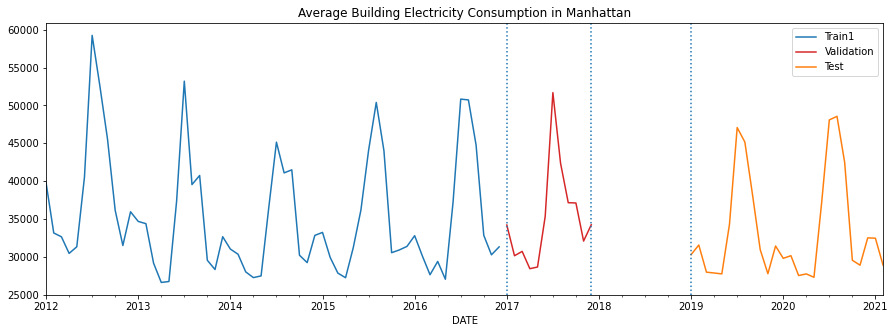

In [4]:
# 1st version of the train set
ax = train["Consumption (KWH)"].plot(figsize=(15,5), color="tab:blue", label='Train1')
_ = val["Consumption (KWH)"].plot(ax=ax, color="tab:red", label='Validation')
_ = test["Consumption (KWH)"].plot(ax=ax, color="tab:orange", label='Test')

plt.title("Average Building Electricity Consumption in Manhattan")
ax.legend()
ax.axvline(val.index[0], linestyle=":")
ax.axvline(val.index[-1], linestyle=":")
ax.axvline(test.index[0], linestyle=":");

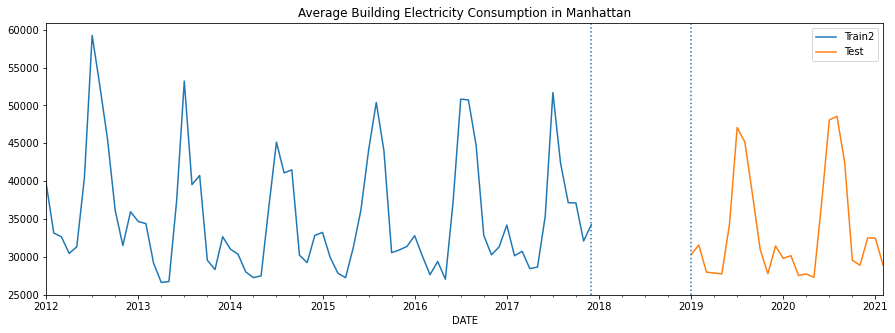

In [5]:
# 2nd version of the train set
ax = data["Consumption (KWH)"].plot(figsize=(15,5), color="tab:blue", label='Train2')
_ = test["Consumption (KWH)"].plot(ax=ax, color="tab:orange", label='Test')

plt.title("Average Building Electricity Consumption in Manhattan")
ax.legend()
ax.axvline(data.index[-1], linestyle=":")
ax.axvline(test.index[0], linestyle=":");

# Modeling <a class="anchor" id="chapter2"></a>

First, I will train the data using VAR (Vector AutoRegression) and VARMAX (Vector Autoregression Moving-Average with Exogenous Regressors). The basis behind these models is that this month's electricity consumption is affected not only by the last month's a consumption but also by the last month's temperature. This means that you can predict the future electricity consumption with past values of itself along with past values of temperature.

The key for VAR and VARMAX modeling is that you have to find the optimal order (lag) value. To find this, you can use an attribute like ".select_order()".

For the evaluation metrics, I will focus on RMSE (Root Mean Squared Error), which will show how much kWh are off, and MAPE (Mean Average Percentage Error), which will express the forecast error by how many percentage points the forecasts are off on average. 

## VAR Model <a class="anchor" id="section_2_1"></a>

The Vector AutoRegression (VAR) is a forecasting algorithm that can be used when two or more time series influence each other. It is important to note that the VAR model requires stationary time series.

### Using Train Set Version 1 <a class="anchor" id="section_2_1_1"></a>

In [6]:
# instantiating VAR model
var_model = VAR(df_differenced)

# finding optimal order(p) of the VAR model
var_model.select_order().summary()

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


,AIC,BIC,FPE,HQIC
0,47.65,47.95,4.938e+20,47.76
1,44.80,47.48,2.950e+19,45.83
2,42.39,47.44,3.090e+18,44.33
3,40.60,48.03,8.169e+17,43.45
4,37.90,47.71,1.585e+17,41.67
5,23.93*,36.13*,1.481e+12*,28.62*


>The optimal lag is observed at a lag order of 5.

In [7]:
var_result = var_model.fit(5)
var_result.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 15, Sep, 2021
Time:                     13:24:29
--------------------------------------------------------------------
No. of Equations:         8.00000    BIC:                    36.1273
Nobs:                     53.0000    HQIC:                   28.6228
Log likelihood:          -907.876    FPE:                1.48073e+12
AIC:                      23.9338    Det(Omega_mle):     1.51238e+10
--------------------------------------------------------------------
Results for equation Consumption (KWH)
                                    coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------------------
const                                -74.614850       289.454336           -0.258           0.797
L1.Consumption (KWH)                  -0.720929         0.135593           -5.

>After fitting the model with the optimal order, 5 in this case, I get the equations for all time series variables. Here, I only care about the consumption time series so I focus on the equation for the consumption. The way I interpret this is that first, I observe which variable is most influential in prediction by looking at the p-values ('prob' column in the above result). I consider those under 0.05 are contributing to the consumption prediction the most. My equation is made up of coefficients of all the time series.

In [8]:
# getting the lag order
lag_order = var_result.k_ar
print(lag_order)  

# input data for forecasting
forecast_input = df_differenced.values[-lag_order:]
forecast_input

5


array([[-1.37329737e+04,  8.70000000e+00, -7.20000000e+00,
        -4.50000000e+00,  2.12150000e+03, -3.20000000e+00,
        -2.70000000e+00, -3.80000000e+00],
       [-5.87072382e+03, -1.20300000e+02, -2.80000000e+00,
        -2.80000000e+00,  1.06000000e+01, -4.40000000e+00,
        -4.40000000e+00, -4.40000000e+00],
       [-5.93893873e+03, -1.07900000e+02, -5.00000000e+00,
        -6.00000000e-01,  1.12900000e+02, -3.10000000e+00,
        -3.10000000e+00, -3.10000000e+00],
       [ 9.34308217e+03, -1.61000000e+01,  6.70000000e+00,
        -3.80000000e+00,  1.30500000e+02,  2.20000000e+00,
         2.20000000e+00,  2.20000000e+00],
       [ 3.62221138e+03,  0.00000000e+00, -7.10000000e+00,
         6.00000000e-01,  2.04600000e+02, -1.40000000e+00,
        -2.00000000e+00, -7.00000000e-01]])

In [9]:
# forecasting
var_pred = var_result.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(var_pred, index=data.index[-nobs:], columns=data.columns + '_2d')
df_forecast

,Consumption (KWH)_2d,Cooling Degree Days Season_2d,Extreme Minimum Temperature_2d,Extreme Maximum Temperature_2d,Heating Degree Days Season_2d,Average Temperature_2d,Maximum Temperature_2d,Minimum Temperature_2d
DATE,,,,,,,,
2017-01-01,10048.079349,-559.789368,4.895119,12.907195,-142.315741,4.855177,5.578807,3.746367
2017-02-01,-21428.619086,446.244659,2.513900,-16.897314,156.171158,-0.814898,0.439633,-1.577696
2017-03-01,4338.232557,59.840656,4.202308,15.477686,398.125782,1.623034,0.317848,2.827747
2017-04-01,3197.900732,98.979888,-0.658933,5.897281,-864.423049,7.973522,8.227996,7.441036
2017-05-01,3653.705992,-63.349063,12.437010,-10.014881,164.350632,-0.665107,0.041133,-1.110028
2017-06-01,17450.582668,210.559842,-14.432602,4.985419,101.595421,-2.047035,-3.518252,-0.791657
2017-07-01,-16874.075444,-117.938836,5.432065,-3.553500,-2352.905442,-2.196893,-2.150008,-2.077395
2017-08-01,-3394.369821,111.772335,-7.306630,-9.247682,1405.899352,-5.534762,-4.371605,-6.550388
2017-09-01,-1076.327497,110.787361,1.245983,14.687331,968.612408,2.192221,1.117793,2.893127


>The forecasts are generated but it is on the scale of the training data used by the model. Thus, to bring it back up to its original scale, I need to de-difference it as many times I had differenced the original input data. In this case, it is two times.

In [10]:
# inverted results in a dataframe
df_var_results = invert_transformation(train, df_forecast, second_diff=True)        
df_var_results

,Consumption (KWH)_2d,Cooling Degree Days Season_2d,Extreme Minimum Temperature_2d,Extreme Maximum Temperature_2d,Heating Degree Days Season_2d,Average Temperature_2d,Maximum Temperature_2d,Minimum Temperature_2d,Consumption (KWH)_1d,Consumption (KWH)_forecast,...,Extreme Maximum Temperature_1d,Extreme Maximum Temperature_forecast,Heating Degree Days Season_1d,Heating Degree Days Season_forecast,Average Temperature_1d,Average Temperature_forecast,Maximum Temperature_1d,Maximum Temperature_forecast,Minimum Temperature_1d,Minimum Temperature_forecast
DATE,,,,,,,,,,,,,,,,,,,,,
2017-01-01,10048.079349,-559.789368,4.895119,12.907195,-142.315741,4.855177,5.578807,3.746367,11096.194865,42402.389084,...,6.307195,21.907195,316.284259,1162.984259,-1.544823,1.955177,-1.521193,5.078807,-1.853633,-1.353633
2017-02-01,-21428.619086,446.244659,2.513900,-16.897314,156.171158,-0.814898,0.439633,-1.577696,-10332.424222,32069.964863,...,-10.590119,11.317076,472.455417,1635.439676,-2.359722,-0.404545,-1.081560,3.997247,-3.431329,-4.784962
2017-03-01,4338.232557,59.840656,4.202308,15.477686,398.125782,1.623034,0.317848,2.827747,-5994.191665,26075.773198,...,4.887567,16.204644,870.581199,2506.020875,-0.736688,-1.141233,-0.763712,3.233535,-0.603582,-5.388544
2017-04-01,3197.900732,98.979888,-0.658933,5.897281,-864.423049,7.973522,8.227996,7.441036,-2796.290933,23279.482265,...,10.784848,26.989491,6.158150,2512.179025,7.236834,6.095601,7.464284,10.697819,6.837453,1.448909
2017-05-01,3653.705992,-63.349063,12.437010,-10.014881,164.350632,-0.665107,0.041133,-1.110028,857.415059,24136.897324,...,0.769967,27.759458,170.508782,2682.687807,6.571728,12.667329,7.505417,18.203236,5.727425,7.176334
2017-06-01,17450.582668,210.559842,-14.432602,4.985419,101.595421,-2.047035,-3.518252,-0.791657,18307.997727,42444.895051,...,5.755386,33.514844,272.104202,2954.792009,4.524693,17.192022,3.987165,22.190402,4.935768,12.112103
2017-07-01,-16874.075444,-117.938836,5.432065,-3.553500,-2352.905442,-2.196893,-2.150008,-2.077395,1433.922283,43878.817334,...,2.201886,35.716730,-2080.801240,873.990769,2.327800,19.519822,1.837158,24.027559,2.858373,14.970476
2017-08-01,-3394.369821,111.772335,-7.306630,-9.247682,1405.899352,-5.534762,-4.371605,-6.550388,-1960.447538,41918.369796,...,-7.045797,28.670933,-674.901888,199.088882,-3.206962,16.312860,-2.534447,21.493112,-3.692015,11.278461
2017-09-01,-1076.327497,110.787361,1.245983,14.687331,968.612408,2.192221,1.117793,2.893127,-3036.775035,38881.594762,...,7.641534,36.312467,293.710520,492.799401,-1.014741,15.298119,-1.416654,20.076458,-0.798888,10.479573


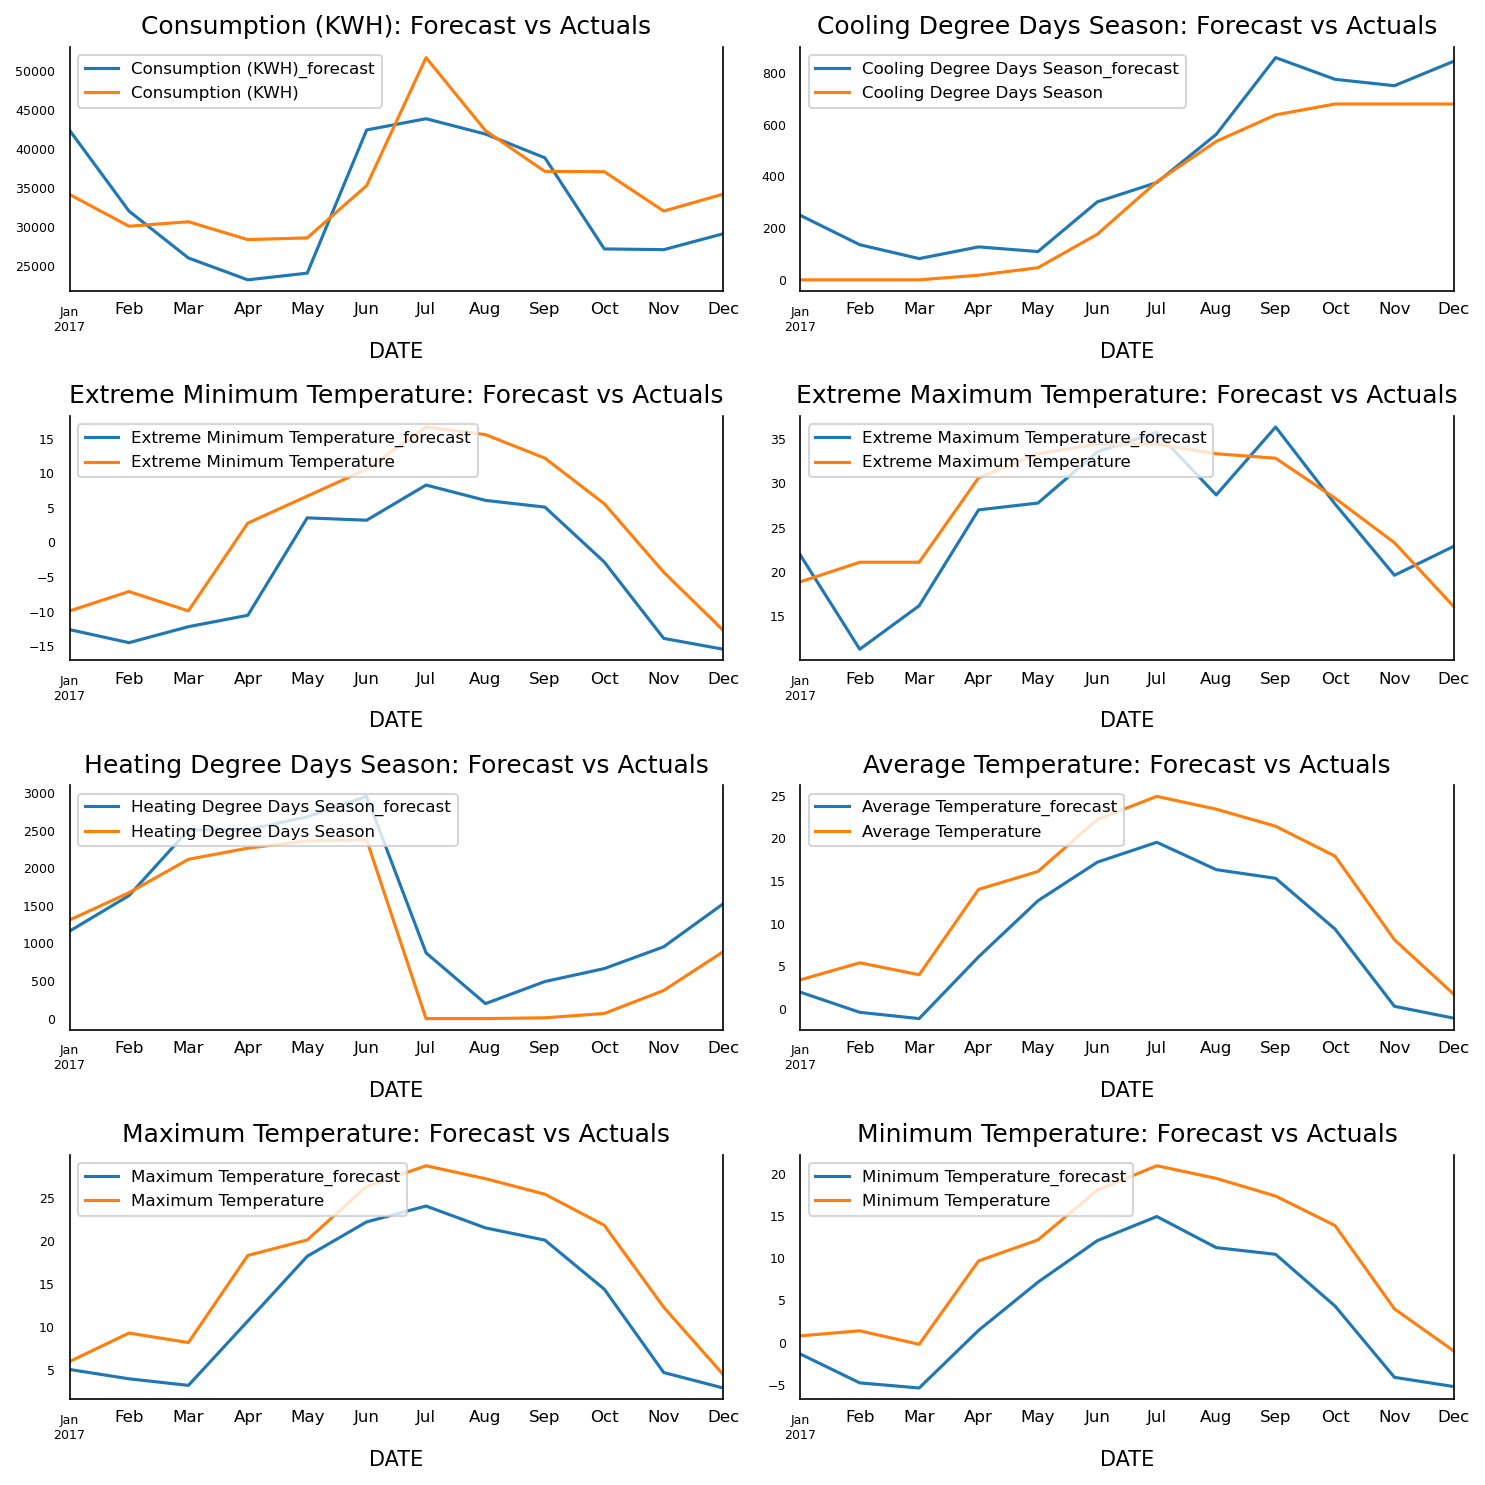

In [11]:
# plotting forecast vs actuals
fig, axes = plt.subplots(nrows=int(len(data.columns)/2), ncols=2, dpi=150, figsize=(10,10))

for i, (col,ax) in enumerate(zip(data.columns, axes.flatten())):
    df_var_results[col+'_forecast'].plot(legend=True, ax=ax, ).autoscale(axis='x',tight=True)
    val[col][-nobs:].plot(legend=True, ax=ax, fontsize=8)
    
    ax.set_title(col + ": Forecast vs Actuals", fontsize=12)
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)
    ax.legend(loc='upper left', fontsize=8)

plt.tight_layout();

In [12]:
print('Forecast Accuracy of: Consumption (KWH)')
accuracy = forecast_accuracy(df_var_results['Consumption (KWH)_forecast'].values, val['Consumption (KWH)'])
for k, v in accuracy.items():
    print(adjust(k), ': ', round(v,4))

Forecast Accuracy of: Consumption (KWH)
mape   :  0.1476
me     :  -1952.1988
mae    :  5116.9098
mpe    :  -0.0555
rmse   :  5785.6718
corr   :  0.7153
minmax :  0.1404


<ipython-input-3-c1ab6c124262>:13: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)
<ipython-input-3-c1ab6c124262>:15: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)


In [13]:
# tracking model performance
performance = []
performance.append('VAR val (train1) - RMSE: 5,785. MAPE: 15%')
performance

['VAR val (train1) - RMSE: 5,785. MAPE: 15%']

>The VAR forecast for the electricity consumption is off by around 5,785 KWH. About 15% of forecasted data points are off on average. 

#### Predicting Test set

In [14]:
# forecasting
var_pred_test = var_result.forecast(y=forecast_input, steps=test_nobs)
df_forecast_test = pd.DataFrame(var_pred_test, index=manhattan_data.index[-test_nobs:], columns=manhattan_data.columns + '_2d')
df_forecast_test

,Consumption (KWH)_2d,Cooling Degree Days Season_2d,Extreme Minimum Temperature_2d,Extreme Maximum Temperature_2d,Heating Degree Days Season_2d,Average Temperature_2d,Maximum Temperature_2d,Minimum Temperature_2d
DATE,,,,,,,,
2019-01-01,10048.079349,-559.789368,4.895119,12.907195,-142.315741,4.855177,5.578807,3.746367
2019-02-01,-21428.619086,446.244659,2.513900,-16.897314,156.171158,-0.814898,0.439633,-1.577696
2019-03-01,4338.232557,59.840656,4.202308,15.477686,398.125782,1.623034,0.317848,2.827747
2019-04-01,3197.900732,98.979888,-0.658933,5.897281,-864.423049,7.973522,8.227996,7.441036
2019-05-01,3653.705992,-63.349063,12.437010,-10.014881,164.350632,-0.665107,0.041133,-1.110028
2019-06-01,17450.582668,210.559842,-14.432602,4.985419,101.595421,-2.047035,-3.518252,-0.791657
2019-07-01,-16874.075444,-117.938836,5.432065,-3.553500,-2352.905442,-2.196893,-2.150008,-2.077395
2019-08-01,-3394.369821,111.772335,-7.306630,-9.247682,1405.899352,-5.534762,-4.371605,-6.550388
2019-09-01,-1076.327497,110.787361,1.245983,14.687331,968.612408,2.192221,1.117793,2.893127


In [15]:
df_var_results_test = invert_transformation(train, df_forecast_test, second_diff=True)        
df_var_results_test

,Consumption (KWH)_2d,Cooling Degree Days Season_2d,Extreme Minimum Temperature_2d,Extreme Maximum Temperature_2d,Heating Degree Days Season_2d,Average Temperature_2d,Maximum Temperature_2d,Minimum Temperature_2d,Consumption (KWH)_1d,Consumption (KWH)_forecast,...,Extreme Maximum Temperature_1d,Extreme Maximum Temperature_forecast,Heating Degree Days Season_1d,Heating Degree Days Season_forecast,Average Temperature_1d,Average Temperature_forecast,Maximum Temperature_1d,Maximum Temperature_forecast,Minimum Temperature_1d,Minimum Temperature_forecast
DATE,,,,,,,,,,,,,,,,,,,,,
2019-01-01,10048.079349,-559.789368,4.895119,12.907195,-142.315741,4.855177,5.578807,3.746367,11096.194865,42402.389084,...,6.307195,21.907195,316.284259,1162.984259,-1.544823,1.955177,-1.521193,5.078807,-1.853633,-1.353633
2019-02-01,-21428.619086,446.244659,2.513900,-16.897314,156.171158,-0.814898,0.439633,-1.577696,-10332.424222,32069.964863,...,-10.590119,11.317076,472.455417,1635.439676,-2.359722,-0.404545,-1.081560,3.997247,-3.431329,-4.784962
2019-03-01,4338.232557,59.840656,4.202308,15.477686,398.125782,1.623034,0.317848,2.827747,-5994.191665,26075.773198,...,4.887567,16.204644,870.581199,2506.020875,-0.736688,-1.141233,-0.763712,3.233535,-0.603582,-5.388544
2019-04-01,3197.900732,98.979888,-0.658933,5.897281,-864.423049,7.973522,8.227996,7.441036,-2796.290933,23279.482265,...,10.784848,26.989491,6.158150,2512.179025,7.236834,6.095601,7.464284,10.697819,6.837453,1.448909
2019-05-01,3653.705992,-63.349063,12.437010,-10.014881,164.350632,-0.665107,0.041133,-1.110028,857.415059,24136.897324,...,0.769967,27.759458,170.508782,2682.687807,6.571728,12.667329,7.505417,18.203236,5.727425,7.176334
2019-06-01,17450.582668,210.559842,-14.432602,4.985419,101.595421,-2.047035,-3.518252,-0.791657,18307.997727,42444.895051,...,5.755386,33.514844,272.104202,2954.792009,4.524693,17.192022,3.987165,22.190402,4.935768,12.112103
2019-07-01,-16874.075444,-117.938836,5.432065,-3.553500,-2352.905442,-2.196893,-2.150008,-2.077395,1433.922283,43878.817334,...,2.201886,35.716730,-2080.801240,873.990769,2.327800,19.519822,1.837158,24.027559,2.858373,14.970476
2019-08-01,-3394.369821,111.772335,-7.306630,-9.247682,1405.899352,-5.534762,-4.371605,-6.550388,-1960.447538,41918.369796,...,-7.045797,28.670933,-674.901888,199.088882,-3.206962,16.312860,-2.534447,21.493112,-3.692015,11.278461
2019-09-01,-1076.327497,110.787361,1.245983,14.687331,968.612408,2.192221,1.117793,2.893127,-3036.775035,38881.594762,...,7.641534,36.312467,293.710520,492.799401,-1.014741,15.298119,-1.416654,20.076458,-0.798888,10.479573


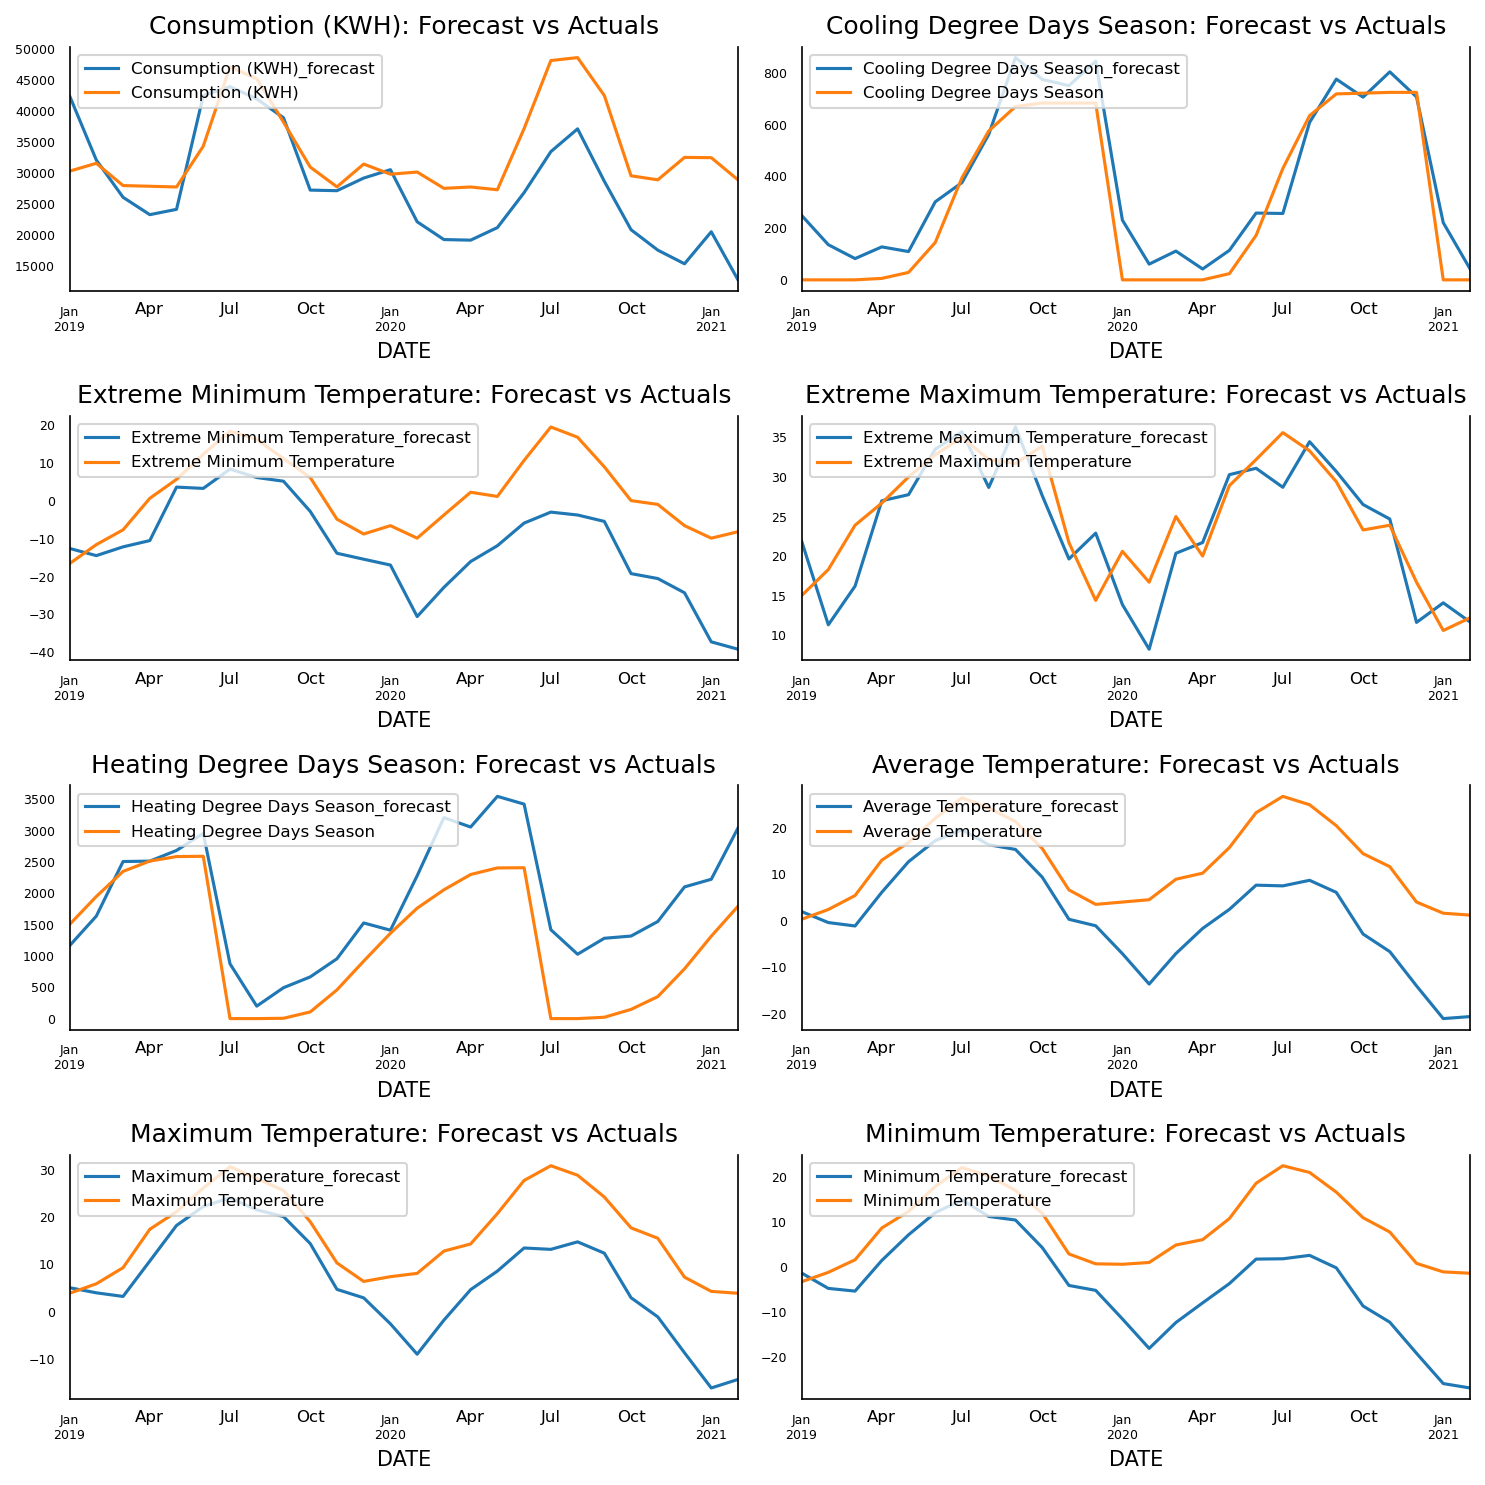

In [16]:
# plotting forecast vs actuals
fig, axes = plt.subplots(nrows=int(len(manhattan_data.columns)/2), ncols=2, dpi=150, figsize=(10,10))

for i, (col,ax) in enumerate(zip(manhattan_data.columns, axes.flatten())):
    df_var_results_test[col+'_forecast'].plot(legend=True, ax=ax, fontsize=8).autoscale(axis='x',tight=True)
    test[col][-test_nobs:].plot(legend=True, ax=ax)
    
    ax.set_title(col + ": Forecast vs Actuals", fontsize=12)
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)
    ax.legend(loc='upper left', fontsize=8)

plt.tight_layout();

In [17]:
print('Forecast Accuracy of: Consumption (KWH)')
accuracy_test = forecast_accuracy(df_var_results_test['Consumption (KWH)_forecast'].values, test['Consumption (KWH)'])
for k, v in accuracy_test.items():
    print(adjust(k), ': ', round(v,4))

Forecast Accuracy of: Consumption (KWH)
mape   :  0.2227
me     :  -5659.8349
mae    :  7368.0266
mpe    :  -0.1691
rmse   :  8934.2114
corr   :  0.6334
minmax :  0.2165


<ipython-input-3-c1ab6c124262>:13: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)
<ipython-input-3-c1ab6c124262>:15: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)


In [18]:
performance.append('VAR test (train1) - RMSE: 8,934. MAPE: 22%')
performance

['VAR val (train1) - RMSE: 5,785. MAPE: 15%',
 'VAR test (train1) - RMSE: 8,934. MAPE: 22%']

>The VAR forecast for the electricity consumption in the test set is off by around 8,934 KWH. About 22% of forecasted data points are off on average, which is worse than the validation set forecast. This might be due to the gap between the validation set and the test set. It could be the size of training data or just the algorithm not performing well. Let's see how model performs with more training data.

### Using Train Set Version 2 <a class="anchor" id="section_2_1_2"></a>

In [19]:
# instantiating VAR model
var_model2 = VAR(data_differenced)

# finding optimal order(p) of the VAR model
var_model2.select_order().summary()

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


,AIC,BIC,FPE,HQIC
0,47.68,47.95,5.082e+20,47.78
1,44.96,47.39,3.421e+19,45.92
2,43.25,47.84,6.763e+18,45.06
3,41.70,48.45,1.827e+18,44.36
4,40.38,49.28,8.239e+17,43.89
5,32.57,43.64,9.343e+14,36.93
6,25.18*,38.41*,4.298e+12*,30.39*


>The optimal lag is observed at a lag order of 6 when using the second version of the train set. 

In [20]:
var_result2 = var_model2.fit(6)
var_result2.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 15, Sep, 2021
Time:                     13:24:35
--------------------------------------------------------------------
No. of Equations:         8.00000    BIC:                    38.4077
Nobs:                     64.0000    HQIC:                   30.3938
Log likelihood:          -1140.40    FPE:                4.29834e+12
AIC:                      25.1845    Det(Omega_mle):     4.55106e+10
--------------------------------------------------------------------
Results for equation Consumption (KWH)
                                    coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------------------
const                                -42.006687       350.112756           -0.120           0.904
L1.Consumption (KWH)                  -1.095399         0.164550           -6.

In [21]:
# getting the lag order
lag_order = var_result2.k_ar
print(lag_order)  

# input data for forecasting
forecast_input2 = data_differenced.values[-lag_order:]
forecast_input2

6


array([[ 9.67006654e+03,  7.28000000e+01,  2.20000000e+00,
        -1.10000000e+00, -2.39000000e+03, -3.40000000e+00,
        -3.80000000e+00, -3.00000000e+00],
       [-2.56901811e+04, -4.65000000e+01, -7.20000000e+00,
        -1.10000000e+00,  2.37670000e+03, -4.20000000e+00,
        -3.90000000e+00, -4.40000000e+00],
       [ 4.11841633e+03, -5.35000000e+01, -2.30000000e+00,
         6.00000000e-01,  1.02000000e+01, -5.00000000e-01,
        -3.00000000e-01, -6.00000000e-01],
       [ 5.17677928e+03, -6.06000000e+01, -3.20000000e+00,
        -4.00000000e+00,  4.67000000e+01, -1.50000000e+00,
        -1.80000000e+00, -1.40000000e+00],
       [-4.99621179e+03, -4.21000000e+01, -3.30000000e+00,
        -5.00000000e-01,  2.48800000e+02, -6.30000000e+00,
        -5.90000000e+00, -6.40000000e+00],
       [ 7.19278852e+03,  0.00000000e+00,  1.50000000e+00,
        -2.20000000e+00,  2.09000000e+02,  3.40000000e+00,
         1.70000000e+00,  4.90000000e+00]])

In [22]:
# forecasting
var_pred_test2 = var_result2.forecast(y=forecast_input2, steps=test_nobs)
df_forecast_test2 = pd.DataFrame(var_pred_test2, index=manhattan_data.index[-test_nobs:], columns=manhattan_data.columns + '_2d')
df_forecast_test2

,Consumption (KWH)_2d,Cooling Degree Days Season_2d,Extreme Minimum Temperature_2d,Extreme Maximum Temperature_2d,Heating Degree Days Season_2d,Average Temperature_2d,Maximum Temperature_2d,Minimum Temperature_2d
DATE,,,,,,,,
2019-01-01,-3152.462206,-650.985489,-2.190006,7.531131,225.861822,2.253026,4.369130,0.030572
2019-02-01,-119.894631,636.688256,10.886995,-6.479535,-132.520329,1.219863,2.051196,0.433123
2019-03-01,-8276.347477,-61.282325,0.878892,4.747632,136.984189,5.004407,3.283114,7.037481
2019-04-01,8599.230663,-107.645418,6.063013,15.359372,-344.242559,8.795322,9.326316,7.934549
2019-05-01,7895.643413,114.789156,5.617920,-2.277892,-628.169218,0.869617,1.305914,0.522907
2019-06-01,-1298.735356,195.853025,-14.487188,-13.099279,350.463712,-11.552365,-12.294478,-10.923500
2019-07-01,7641.938923,137.263925,4.592389,7.427020,-2640.140047,3.744761,3.225584,4.506830
2019-08-01,-20272.253461,-38.306627,-5.424020,-6.435834,2416.241015,-6.040956,-5.006093,-7.333470
2019-09-01,7692.965696,-42.440845,-3.643884,-4.601280,197.385883,-3.489631,-3.583316,-3.144491


In [23]:
df_var_results_test2 = invert_transformation(data, df_forecast_test2, second_diff=True)        
df_var_results_test2

,Consumption (KWH)_2d,Cooling Degree Days Season_2d,Extreme Minimum Temperature_2d,Extreme Maximum Temperature_2d,Heating Degree Days Season_2d,Average Temperature_2d,Maximum Temperature_2d,Minimum Temperature_2d,Consumption (KWH)_1d,Consumption (KWH)_forecast,...,Extreme Maximum Temperature_1d,Extreme Maximum Temperature_forecast,Heating Degree Days Season_1d,Heating Degree Days Season_forecast,Average Temperature_1d,Average Temperature_forecast,Maximum Temperature_1d,Maximum Temperature_forecast,Minimum Temperature_1d,Minimum Temperature_forecast
DATE,,,,,,,,,,,,,,,,,,,,,
2019-01-01,-3152.462206,-650.985489,-2.190006,7.531131,225.861822,2.253026,4.369130,0.030572,-993.182172,33240.689768,...,0.331131,16.431131,740.861822,1629.861822,-4.146974,-2.446974,-3.430870,1.069130,-4.969428,-5.969428
2019-02-01,-119.894631,636.688256,10.886995,-6.479535,-132.520329,1.219863,2.051196,0.433123,-1113.076803,32127.612965,...,-6.148404,10.282727,608.341492,2238.203314,-2.927112,-5.374086,-1.379674,-0.310544,-4.536305,-10.505733
2019-03-01,-8276.347477,-61.282325,0.878892,4.747632,136.984189,5.004407,3.283114,7.037481,-9389.424280,22738.188684,...,-1.400772,8.881955,745.325681,2983.528995,2.077296,-3.296790,1.903440,1.592896,2.501176,-8.004557
2019-04-01,8599.230663,-107.645418,6.063013,15.359372,-344.242559,8.795322,9.326316,7.934549,-790.193617,21947.995067,...,13.958599,22.840554,401.083122,3384.612118,10.872618,7.575828,11.229756,12.822652,10.435725,2.431168
2019-05-01,7895.643413,114.789156,5.617920,-2.277892,-628.169218,0.869617,1.305914,0.522907,7105.449796,29053.444863,...,11.680707,34.521261,-227.086096,3157.526022,11.742235,19.318062,12.535670,25.358322,10.958632,13.389800
2019-06-01,-1298.735356,195.853025,-14.487188,-13.099279,350.463712,-11.552365,-12.294478,-10.923500,5806.714440,34860.159303,...,-1.418572,33.102689,123.377616,3280.903638,0.189870,19.507932,0.241192,25.599514,0.035132,13.424932
2019-07-01,7641.938923,137.263925,4.592389,7.427020,-2640.140047,3.744761,3.225584,4.506830,13448.653363,48308.812667,...,6.008448,39.111137,-2516.762431,764.141207,3.934631,23.442562,3.466776,29.066291,4.541962,17.966895
2019-08-01,-20272.253461,-38.306627,-5.424020,-6.435834,2416.241015,-6.040956,-5.006093,-7.333470,-6823.600098,41485.212569,...,-0.427386,38.683751,-100.521416,663.619791,-2.106325,21.336237,-1.539316,27.526974,-2.791508,15.175387
2019-09-01,7692.965696,-42.440845,-3.643884,-4.601280,197.385883,-3.489631,-3.583316,-3.144491,869.365598,42354.578166,...,-5.028666,33.655085,96.864467,760.484258,-5.595956,15.740281,-5.122633,22.404342,-5.935999,9.239388


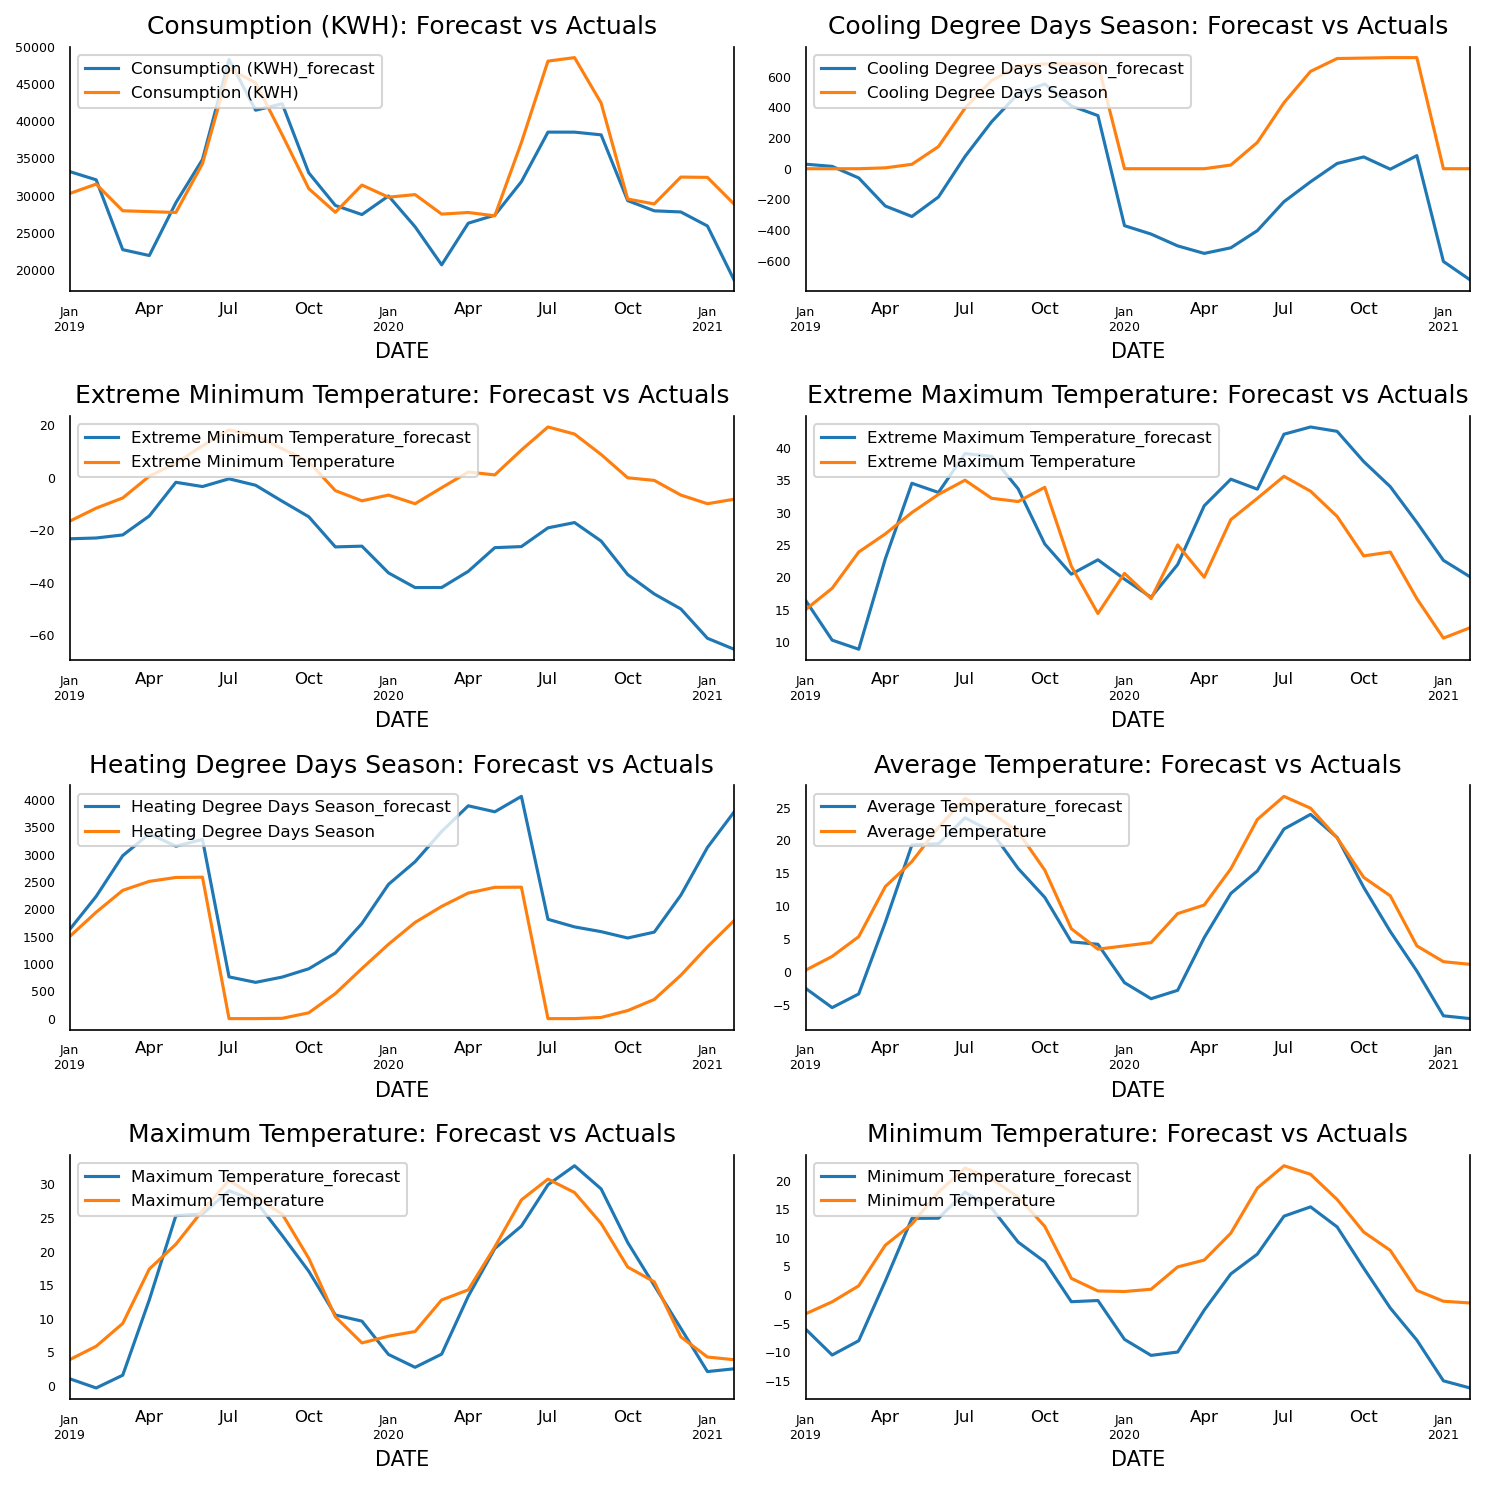

In [24]:
# plotting forecast vs actuals
fig, axes = plt.subplots(nrows=int(len(manhattan_data.columns)/2), ncols=2, dpi=150, figsize=(10,10))

for i, (col,ax) in enumerate(zip(manhattan_data.columns, axes.flatten())):
    df_var_results_test2[col+'_forecast'].plot(legend=True, ax=ax, fontsize=8).autoscale(axis='x',tight=True)
    test[col][-test_nobs:].plot(legend=True, ax=ax)
    
    ax.set_title(col + ": Forecast vs Actuals", fontsize=12)
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)
    ax.legend(loc='upper left', fontsize=8)

plt.tight_layout();

In [25]:
print('Forecast Accuracy of: Consumption (KWH)')
accuracy_test2 = forecast_accuracy(df_var_results_test2['Consumption (KWH)_forecast'].values, test['Consumption (KWH)'])
for k, v in accuracy_test2.items():
    print(adjust(k), ': ', round(v,4))

Forecast Accuracy of: Consumption (KWH)
mape   :  0.11
me     :  -2650.4407
mae    :  3736.3097
mpe    :  -0.0773
rmse   :  4809.3654
corr   :  0.8322
minmax :  0.1089


<ipython-input-3-c1ab6c124262>:13: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)
<ipython-input-3-c1ab6c124262>:15: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)


In [26]:
performance.append('VAR test (train2) - RMSE: 4,809. MAPE: 11%')
performance

['VAR val (train1) - RMSE: 5,785. MAPE: 15%',
 'VAR test (train1) - RMSE: 8,934. MAPE: 22%',
 'VAR test (train2) - RMSE: 4,809. MAPE: 11%']

>With the 2nd version of the train set, the VAR forecast for the electricity consumption in the test set is off by around 4,809 KWH. About 11% of forecasted data points are off on average, which is better than the previous results. 

## VARMAX Model <a class="anchor" id="section_2_2"></a>

The Vector Autoregression Moving-Average with Exogenous Regressors (VARMAX) is a multivariate version of the ARMAX model. It can be used when variables are not only contemporaneously correlated to each other, but they are also correlated to each other's past values.

### Using Train Set Version 1 <a class="anchor" id="section_2_2_1"></a>

In [27]:
varmax_model = VARMAX(train, enforce_stationarity=True, order=(5,0))

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


In [28]:
varmax_result = varmax_model.fit(disp=False)
varmax_result.summary()

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/statespace/varmax.py:374: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Dep. Variable:,"['Consumption (KWH)', 'Cooling Degree Days Season', 'Extreme Minimum Temperature', 'Extreme Maximum Temperature', 'Heating Degree Days Season', 'Average Temperature', 'Maximum Temperature', 'Minimum Temperature']",No. Observations:,60
Model:,VAR(5),Log Likelihood,-1811.344
,+ intercept,AIC,4350.689
Date:,"Wed, 15 Sep 2021",BIC,5113.030
Time:,13:25:58,HQIC,4648.882
Sample:,01-01-2012,,
,- 12-01-2016,,
Covariance Type:,opg,,
Ljung-Box (L1) (Q):,"5.77, 1.99, 0.31, 4.70, 2.40, 11.76, 0.09, 8.11",Jarque-Bera (JB):,"20.82, 2.03, 4.38, 3.29, 12.01, 1.19, 12.70, 1.07"
Prob(Q):,"0.02, 0.16, 0.58, 0.03, 0.12, 0.00, 0.76, 0.00",Prob(JB):,"0.00, 0.36, 0.11, 0.19, 0.00, 0.55, 0.00, 0.59"
Heteroskedasticity (H):,"0.36, 1.56, 1.13, 0.29, 1.54, 0.79, 0.89, 0.81",Skew:,"0.97, 0.30, -0.62, -0.54, 0.77, -0.22, 0.42, 0.01"


In [29]:
varmax_pred = varmax_result.get_prediction(start='2017-01-01', end='2017-12-01')
predictions = varmax_pred.predicted_mean

In [30]:
predictions.columns=data.columns + '_pred'
predictions

,Consumption (KWH)_pred,Cooling Degree Days Season_pred,Extreme Minimum Temperature_pred,Extreme Maximum Temperature_pred,Heating Degree Days Season_pred,Average Temperature_pred,Maximum Temperature_pred,Minimum Temperature_pred
2017-01-01,31610.391365,243.422727,-8.956014,16.447803,1255.328381,3.633258,6.860564,0.278056
2017-02-01,31400.336488,25.998221,-11.532131,14.487546,1672.553876,2.758527,6.245281,-0.843131
2017-03-01,27942.227863,2.166888,-7.221657,19.668686,2187.986765,6.517196,10.643564,2.530527
2017-04-01,26931.722691,-15.153118,-1.954747,25.177416,2326.733035,11.154224,15.854977,6.732485
2017-05-01,29662.317763,66.671936,5.257019,30.476075,2180.312409,16.677197,21.648576,11.985729
2017-06-01,34938.760082,263.537143,9.671654,32.421852,1801.824856,19.872908,24.662819,15.274870
2017-07-01,41377.689830,406.382754,13.263897,33.655831,1000.239774,22.255064,26.699603,17.762889
2017-08-01,43100.658332,532.273002,12.335206,32.241433,427.136635,21.198767,25.355525,16.899988
2017-09-01,42118.284736,618.395551,9.170608,30.153522,214.462424,18.452371,22.385557,14.402805
2017-10-01,37666.299864,608.217347,4.254048,27.028547,353.006790,14.490172,18.213762,10.721853


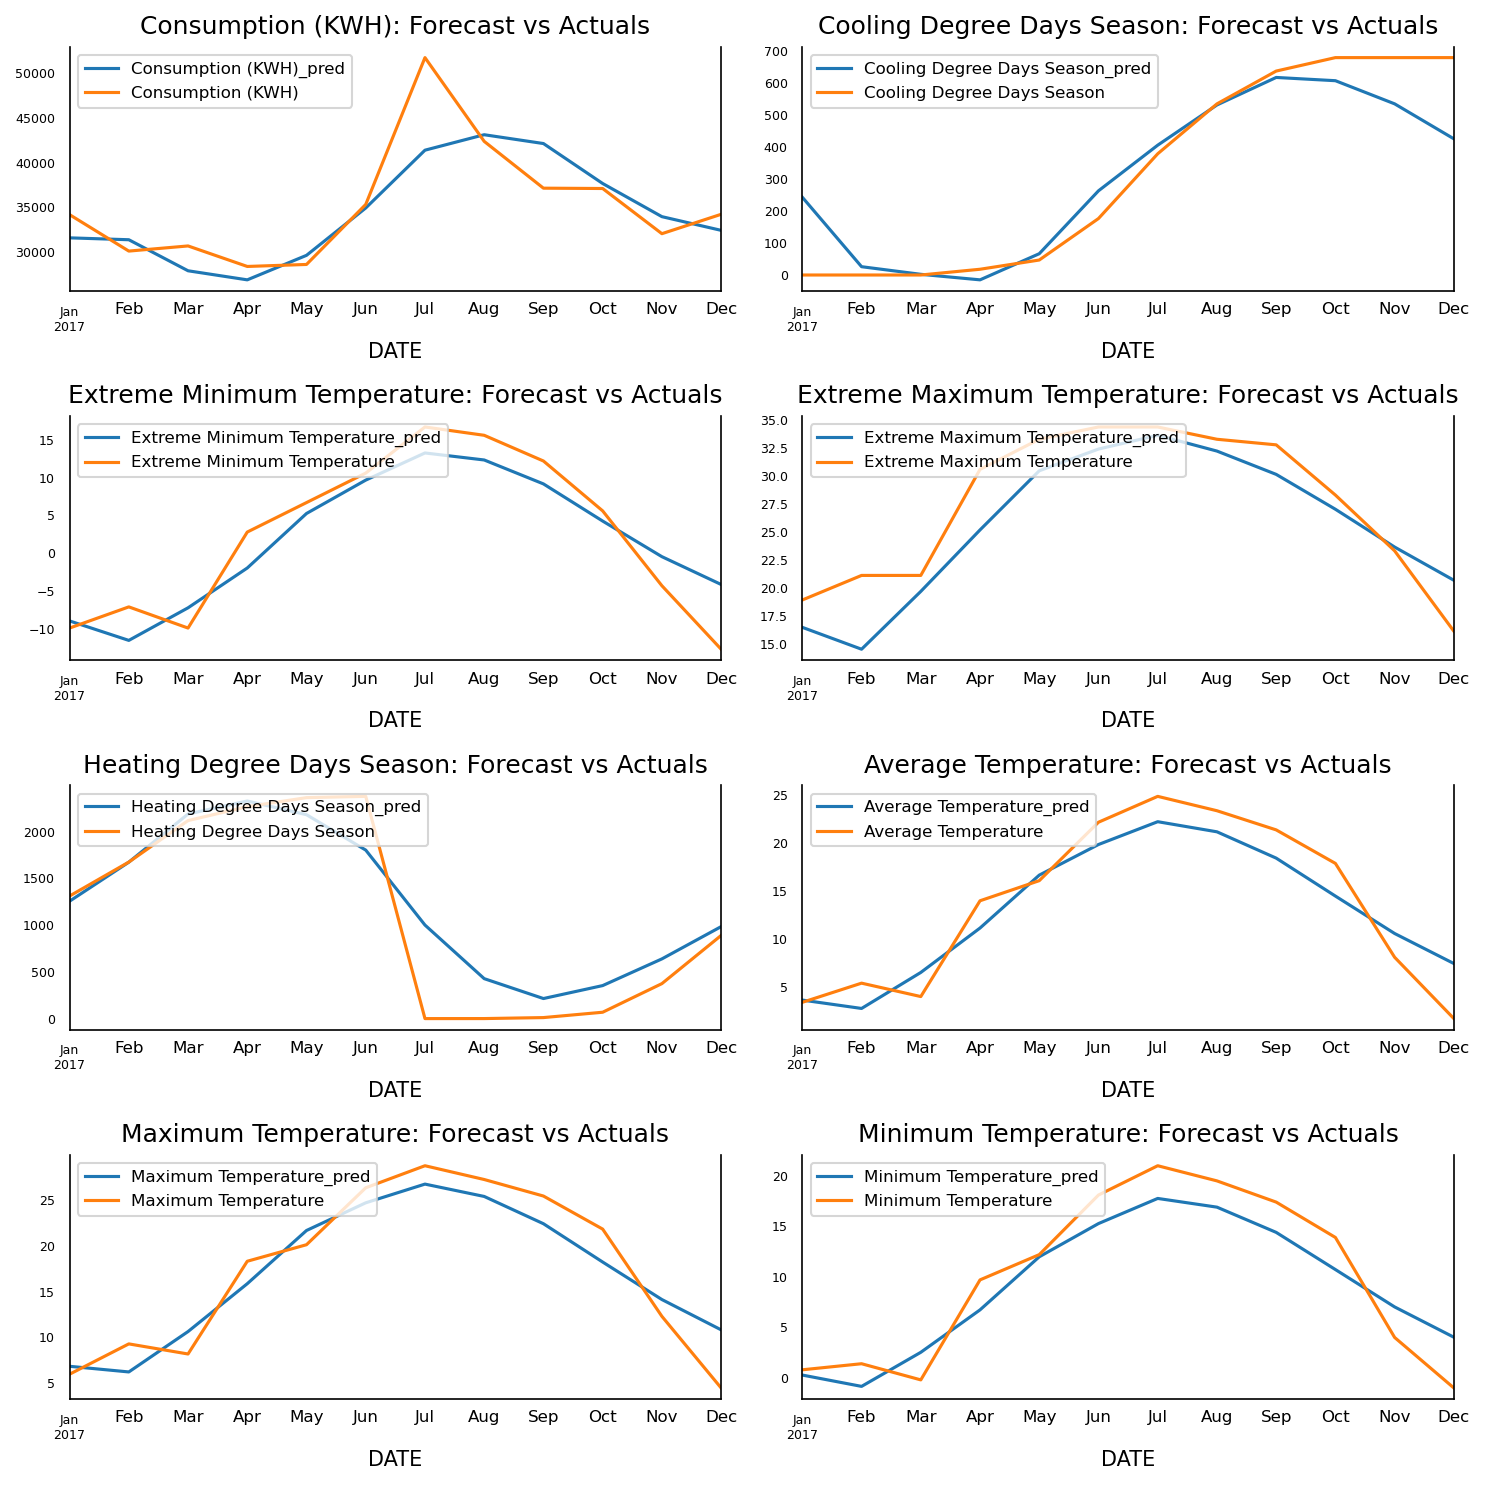

In [31]:
fig, axes = plt.subplots(nrows=int(len(data.columns)/2), ncols=2, dpi=150, figsize=(10,10))

for i, (col,ax) in enumerate(zip(data.columns, axes.flatten())):
    predictions[col+'_pred'].plot(legend=True, ax=ax, fontsize=8).autoscale(axis='x',tight=True)
    val[col][-nobs:].plot(legend=True, ax=ax)
    
    ax.set_title(col + ": Forecast vs Actuals", fontsize=12)
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)
    ax.legend(loc='upper left', fontsize=8)

plt.tight_layout();

In [32]:
print('Forecast Accuracy of: Consumption (KWH)')
accuracy_prod = forecast_accuracy(predictions['Consumption (KWH)_pred'].values, val['Consumption (KWH)'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

Forecast Accuracy of: Consumption (KWH)
mape   :  0.0653
me     :  -740.8312
mae    :  2482.5054
mpe    :  -0.0148
rmse   :  3629.9374
corr   :  0.8262
minmax :  0.0635


<ipython-input-3-c1ab6c124262>:13: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)
<ipython-input-3-c1ab6c124262>:15: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)


In [33]:
performance.append('VARMAX val (train1) - RMSE: 3,630. MAPE: 7%')
performance

['VAR val (train1) - RMSE: 5,785. MAPE: 15%',
 'VAR test (train1) - RMSE: 8,934. MAPE: 22%',
 'VAR test (train2) - RMSE: 4,809. MAPE: 11%',
 'VARMAX val (train1) - RMSE: 3,630. MAPE: 7%']

>The VARMAX forecast for the electricity consumption is off by around 3,630 KWH. About 7% of forecasted data points are off on average, which is better than the VAR forecasts.

#### Predicting Test set

In [34]:
varmax_pred_test = varmax_result.get_prediction(start='2019-01-01', end='2021-02-01')
predictions_test = varmax_pred_test.predicted_mean

In [35]:
predictions_test.columns = manhattan_data.columns + '_pred'
predictions_test

,Consumption (KWH)_pred,Cooling Degree Days Season_pred,Extreme Minimum Temperature_pred,Extreme Maximum Temperature_pred,Heating Degree Days Season_pred,Average Temperature_pred,Maximum Temperature_pred,Minimum Temperature_pred
2019-01-01,32824.304980,292.231862,-2.542078,22.136546,1322.166395,9.179171,12.887337,5.448783
2019-02-01,32898.364245,234.809604,-1.883635,22.743888,1491.699337,9.881920,13.735570,6.022374
2019-03-01,33338.964828,212.450565,-0.156481,24.171642,1579.244009,11.437028,15.468896,7.424406
2019-04-01,34047.801800,228.739302,2.127957,25.957116,1568.638148,13.356029,17.536422,9.216699
2019-05-01,34993.943649,275.178494,4.306040,27.531305,1460.845480,15.074117,19.322746,10.870246
2019-06-01,36032.586472,335.811213,5.781541,28.454961,1283.200645,16.139080,20.361559,11.942855
2019-07-01,36865.213503,392.940113,6.209773,28.553580,1087.199736,16.333764,20.458226,12.204060
2019-08-01,37159.162183,431.887059,5.557925,27.906806,933.103929,15.685817,19.682004,11.655459
2019-09-01,36775.587046,444.435785,4.099749,26.775938,866.841096,14.442949,18.320530,10.516522
2019-10-01,35877.839378,429.718849,2.307868,25.499641,900.924221,12.987080,16.781916,9.144537


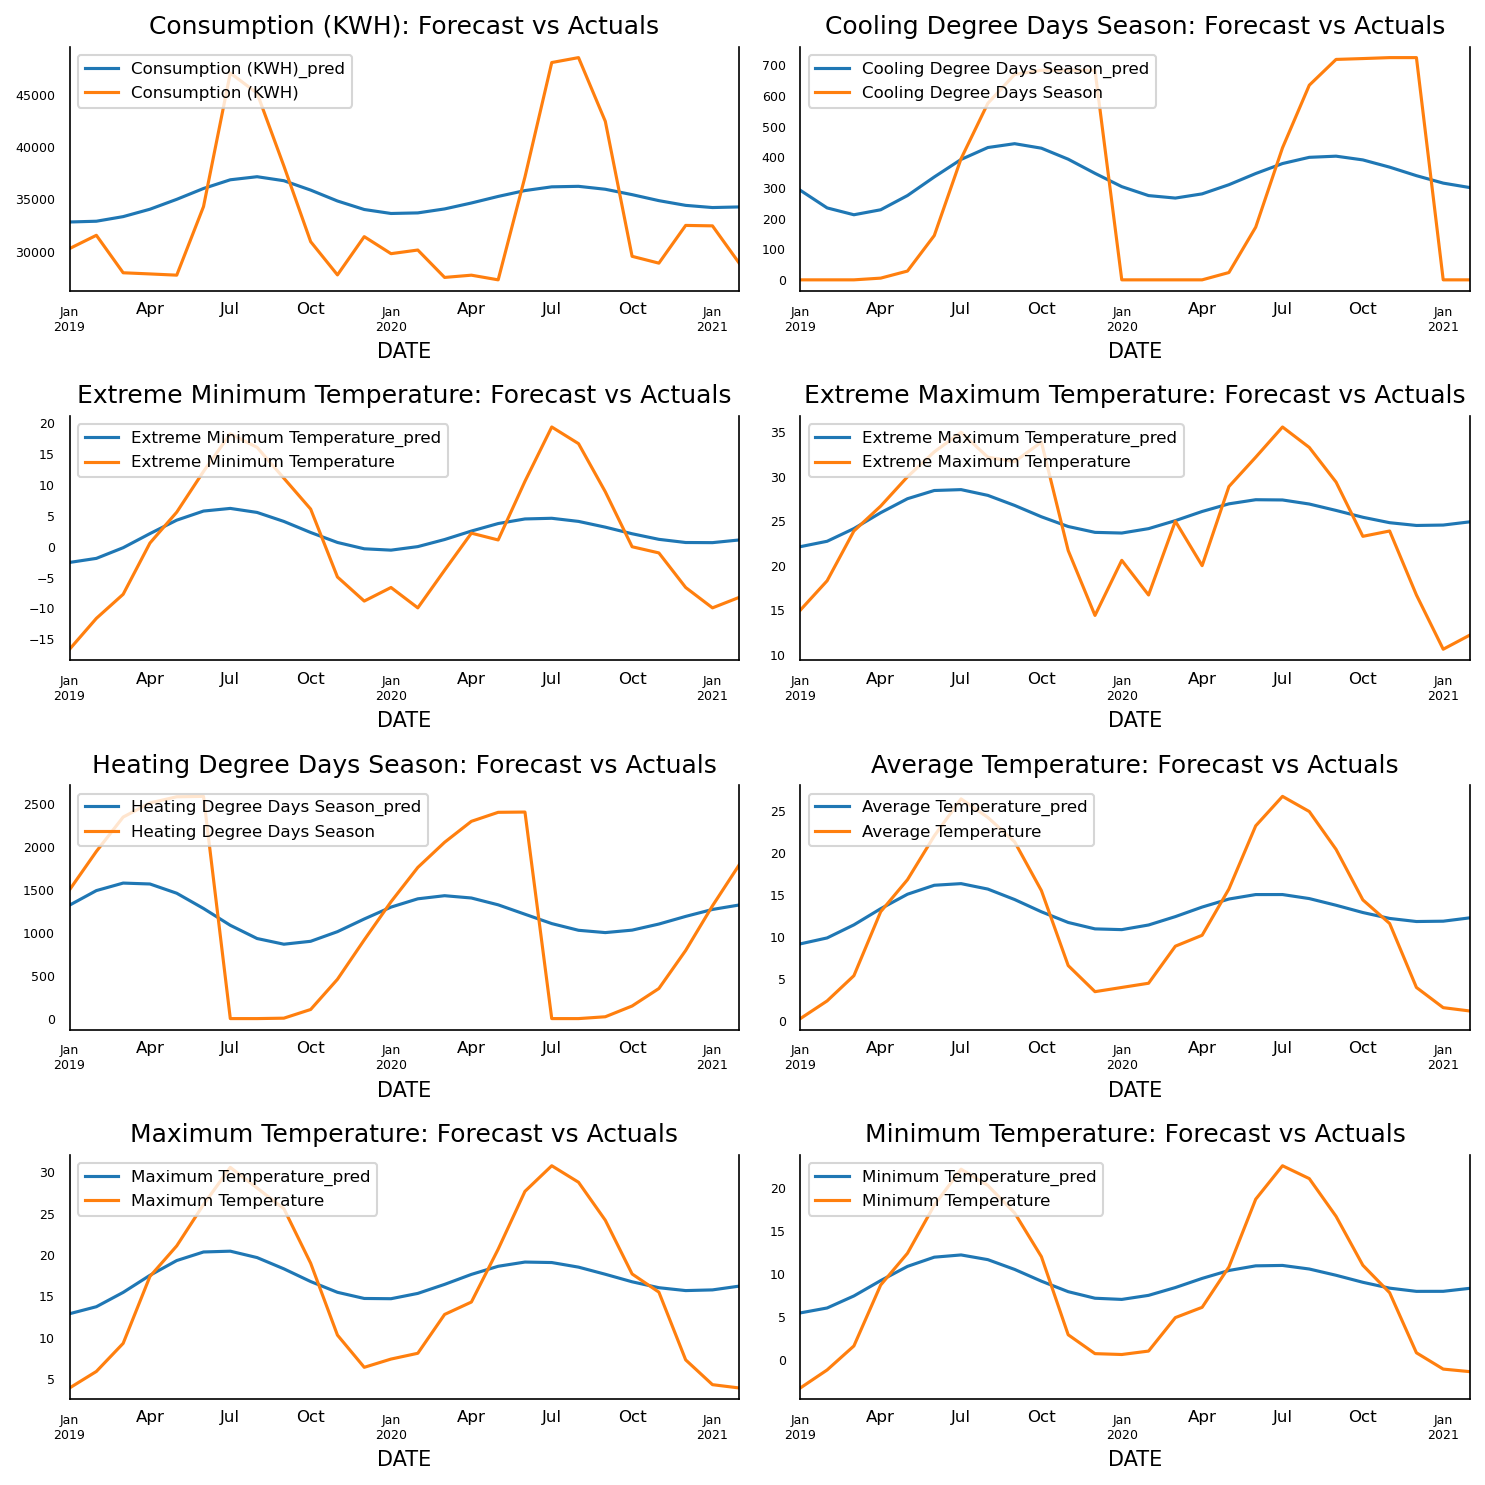

In [36]:
fig, axes = plt.subplots(nrows=int(len(manhattan_data.columns)/2), ncols=2, dpi=150, figsize=(10,10))

for i, (col,ax) in enumerate(zip(manhattan_data.columns, axes.flatten())):
    predictions_test[col+'_pred'].plot(legend=True, ax=ax, fontsize=8).autoscale(axis='x',tight=True)
    test[col][-test_nobs:].plot(legend=True, ax=ax)
    
    ax.set_title(col + ": Forecast vs Actuals", fontsize=12)
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)
    ax.legend(loc='upper left', fontsize=8)

plt.tight_layout();

In [37]:
print('Forecast Accuracy of: Consumption (KWH)')
accuracy_test = forecast_accuracy(predictions_test['Consumption (KWH)_pred'].values, test['Consumption (KWH)'])
for k, v in accuracy_test.items():
    print(adjust(k), ': ', round(v,4))

Forecast Accuracy of: Consumption (KWH)
mape   :  0.1617
me     :  1431.1189
mae    :  5403.3411
mpe    :  0.0755
rmse   :  6227.0907
corr   :  0.7109
minmax :  0.1421


<ipython-input-3-c1ab6c124262>:13: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)
<ipython-input-3-c1ab6c124262>:15: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)


In [38]:
performance.append('VARMAX test (train1) - RMSE: 6,227. MAPE: 16%')
performance

['VAR val (train1) - RMSE: 5,785. MAPE: 15%',
 'VAR test (train1) - RMSE: 8,934. MAPE: 22%',
 'VAR test (train2) - RMSE: 4,809. MAPE: 11%',
 'VARMAX val (train1) - RMSE: 3,630. MAPE: 7%',
 'VARMAX test (train1) - RMSE: 6,227. MAPE: 16%']

>The VARMAX forecast for the electricity consumption in the test set is off by around 6,227 KWH. About 16% of forecasted data points are off on average, which is worse than the validation set forecast. 

### Using Train Set Version 2  <a class="anchor" id="section_2_2_2"></a>

In [39]:
varmax_model2 = VARMAX(data, enforce_stationarity=True, order=(6,0))

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


In [40]:
varmax_result2 = varmax_model2.fit(disp=False)
varmax_result2.summary()

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/statespace/varmax.py:374: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Dep. Variable:,"['Consumption (KWH)', 'Cooling Degree Days Season', 'Extreme Minimum Temperature', 'Extreme Maximum Temperature', 'Heating Degree Days Season', 'Average Temperature', 'Maximum Temperature', 'Minimum Temperature']",No. Observations:,72
Model:,VAR(6),Log Likelihood,-2301.276
,+ intercept,AIC,5458.551
Date:,"Wed, 15 Sep 2021",BIC,6432.964
Time:,13:28:09,HQIC,5846.468
Sample:,01-01-2012,,
,- 12-01-2017,,
Covariance Type:,opg,,
Ljung-Box (L1) (Q):,"7.63, 17.52, 5.49, 9.30, 0.10, 2.27, 0.48, 8.62",Jarque-Bera (JB):,"27.03, 1.72, 2.83, 15.97, 0.03, 0.88, 6.80, 6.51"
Prob(Q):,"0.01, 0.00, 0.02, 0.00, 0.76, 0.13, 0.49, 0.00",Prob(JB):,"0.00, 0.42, 0.24, 0.00, 0.98, 0.64, 0.03, 0.04"
Heteroskedasticity (H):,"0.55, 0.77, 0.97, 0.38, 0.66, 1.17, 2.33, 1.66",Skew:,"1.28, -0.33, -0.48, -0.88, -0.04, 0.15, 0.20, -0.66"


In [41]:
varmax_pred_test2 = varmax_result2.get_prediction(start='2019-01-01', end='2021-02-01')
predictions_test2 = varmax_pred_test2.predicted_mean

In [42]:
predictions_test2.columns = manhattan_data.columns + '_pred'
predictions_test2

,Consumption (KWH)_pred,Cooling Degree Days Season_pred,Extreme Minimum Temperature_pred,Extreme Maximum Temperature_pred,Heating Degree Days Season_pred,Average Temperature_pred,Maximum Temperature_pred,Minimum Temperature_pred
2019-01-01,33253.827951,299.214149,-4.274194,21.218265,959.483251,7.297169,11.172486,3.663717
2019-02-01,30804.140144,199.212198,-4.864156,21.675655,1489.652749,7.527387,11.521862,3.810375
2019-03-01,30765.598867,101.921005,-3.673968,23.052434,1848.891340,8.906311,13.112316,4.931506
2019-04-01,31954.948940,98.250111,-0.683436,25.048300,1929.216951,11.305507,15.586559,7.143259
2019-05-01,33836.040909,143.189096,3.191158,27.288633,1871.612760,14.077307,18.346219,9.815990
2019-06-01,36397.596596,212.440241,6.257133,29.036429,1636.612294,16.474829,20.713760,12.172558
2019-07-01,38290.166805,299.092759,7.999450,30.000409,1178.636371,17.848782,22.150495,13.497148
2019-08-01,38056.918246,439.492573,8.758773,30.189173,906.409444,18.601035,22.674180,14.370351
2019-09-01,38142.669954,534.639767,7.978622,29.552287,654.692103,17.878349,21.754868,13.775157
2019-10-01,36569.007361,559.457587,5.954258,28.056384,595.583235,16.166778,19.911896,12.266969


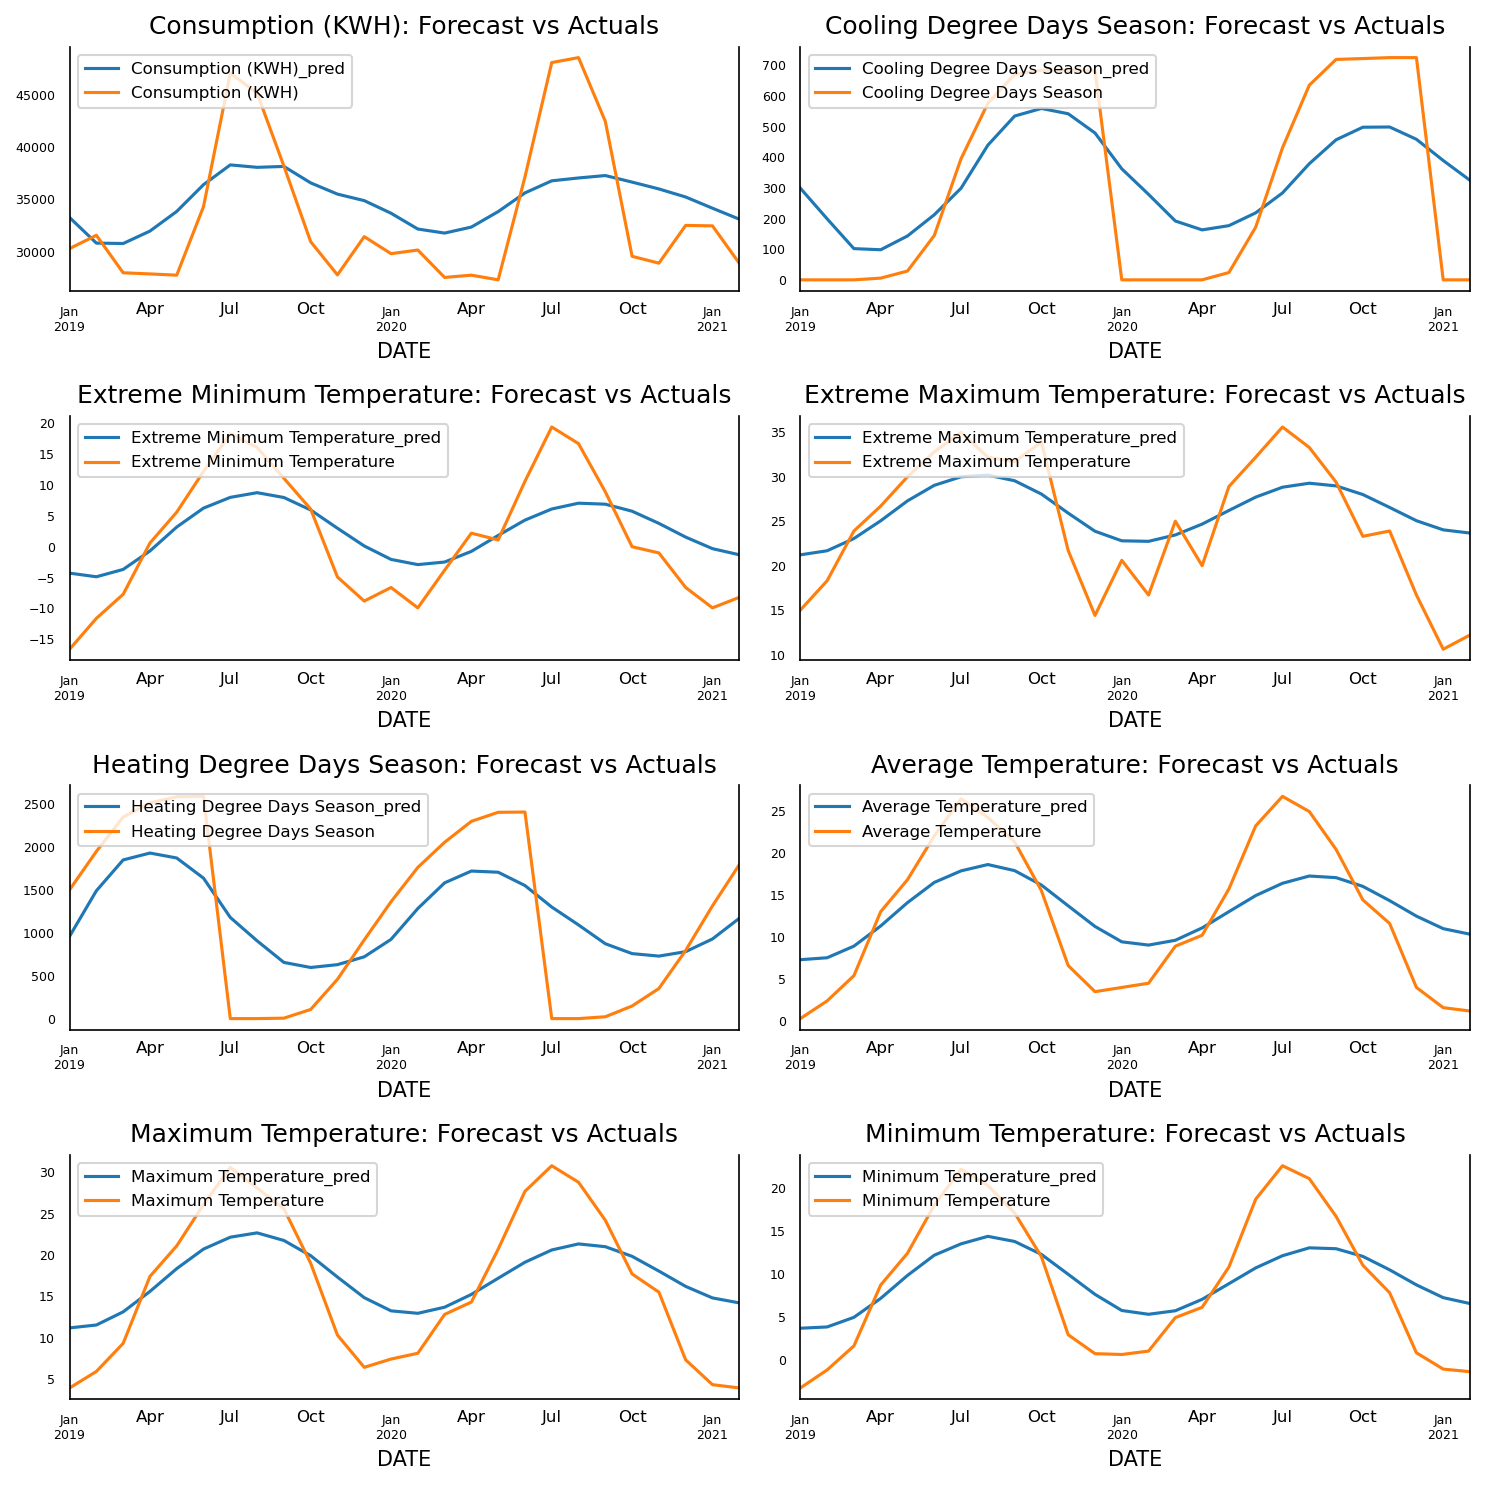

In [43]:
fig, axes = plt.subplots(nrows=int(len(manhattan_data.columns)/2), ncols=2, dpi=150, figsize=(10,10))

for i, (col,ax) in enumerate(zip(manhattan_data.columns, axes.flatten())):
    predictions_test2[col+'_pred'].plot(legend=True, ax=ax, fontsize=8).autoscale(axis='x',tight=True)
    test[col][-test_nobs:].plot(legend=True, ax=ax)
    
    ax.set_title(col + ": Forecast vs Actuals", fontsize=12)
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)
    ax.legend(loc='upper left', fontsize=8)

plt.tight_layout();

In [44]:
print('Forecast Accuracy of: Consumption (KWH)')
accuracy_test2 = forecast_accuracy(predictions_test2['Consumption (KWH)_pred'].values, test['Consumption (KWH)'])
for k, v in accuracy_test2.items():
    print(adjust(k), ': ', round(v,4))

Forecast Accuracy of: Consumption (KWH)
mape   :  0.1433
me     :  1259.1969
mae    :  4815.5492
mpe    :  0.066
rmse   :  5638.5972
corr   :  0.7081
minmax :  0.1275


<ipython-input-3-c1ab6c124262>:13: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)
<ipython-input-3-c1ab6c124262>:15: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)


In [45]:
performance.append('VARMAX test (train2) - RMSE: 5,639. MAPE: 14%')
performance

['VAR val (train1) - RMSE: 5,785. MAPE: 15%',
 'VAR test (train1) - RMSE: 8,934. MAPE: 22%',
 'VAR test (train2) - RMSE: 4,809. MAPE: 11%',
 'VARMAX val (train1) - RMSE: 3,630. MAPE: 7%',
 'VARMAX test (train1) - RMSE: 6,227. MAPE: 16%',
 'VARMAX test (train2) - RMSE: 5,639. MAPE: 14%']

>With the 2nd version of the train set, the VARMAX forecast for the electricity consumption in the test set is off by around 5,639 KWH. About 14% of forecasted data points are off on average, which is better than the previous forecast in the test set but still worse than the validation forecast. So far, it looks like both the seamlessnes and the size of training dataset affect the model's performance. More data will certainly improve the prediction. 